# Exploring Dandiset 000673: Working Memory and Phase-Amplitude Coupling of Human Hippocampal Neurons

## Important Notes

**This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.**

This notebook demonstrates how to explore and analyze data from Dandiset 000673, which contains electrophysiological recordings and behavioral data from human subjects performing a Sternberg working memory task. The dataset includes recordings from intracranial electrodes placed in the medial temporal lobe and medial frontal cortex of epilepsy patients.

## Introduction

In this notebook, we will:

1. Explore the metadata and structure of the Dandiset
2. Load an NWB file and examine its contents
3. Analyze the behavioral performance in the Sternberg working memory task
4. Visualize the local field potentials (LFPs) from different brain regions
5. Examine neural activity patterns during different trial phases
6. Analyze frequency characteristics of the neural signals

### About the Dandiset

This Dandiset (ID: 000673) contains data from a study investigating how cognitive control regulates working memory storage through interactions between frontal control regions and hippocampal persistent activity, coordinated by theta-gamma phase-amplitude coupling (TG-PAC). The researchers recorded single neurons in the human medial temporal and frontal lobe while patients maintained multiple items in their working memory.

### The Sternberg Working Memory Task

The Sternberg task is a classic working memory paradigm in which participants:

1. Encode a set of items (memory set)
2. Maintain this information in working memory during a delay period
3. Respond to a probe item indicating whether it was part of the memory set

In this study, the researchers manipulated memory load (1 or 3 items) to examine how cognitive control demand affects neural activity.

## Setup: Import Required Libraries

First, we'll import the necessary libraries for data loading, analysis, and visualization.

In [1]:
# Standard data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.stats import ttest_ind, zscore

# NWB-specific libraries for neurophysiology data
import pynwb
import h5py
import remfile

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12

## Loading the Dandiset Metadata

Let's first use the DANDI API to get the metadata of the Dandiset and list all available assets (NWB files).

In [2]:
from dandi.dandiapi import DandiAPIClient
client = DandiAPIClient()
dandiset = client.get_dandiset("000673")
assets = list(dandiset.get_assets())

# Display basic information about the Dandiset
print(f"Dandiset ID: {dandiset.identifier}")
# Get metadata (access may vary depending on API version)
try:
    metadata = dandiset.get_metadata()
    print(f"Dandiset Name: {metadata.get('name', 'Not available')}")
except:
    print("Dandiset Name: Not available")
print(f"Version: {dandiset.version}")
print(f"Number of assets: {len(assets)}")

Dandiset ID: 000673
Dandiset Name: Not available
Version: 0.250122.0110
Number of assets: 44


### Listing Available Assets (NWB Files)

Now let's list the NWB files available in this Dandiset, which represent recordings from different subjects and sessions.

In [3]:
# Create a DataFrame to display the assets
assets_info = []
for asset in assets:
    # Extract subject and session info from the path
    path_parts = asset.path.split('/')
    assets_info.append({
        'asset_id': asset.identifier,
        'path': asset.path,
        'size_MB': asset.size / 1024 / 1024,  # Convert to MB
        'subject': path_parts[0] if len(path_parts) > 0 else None,
        'session': path_parts[1].split('_')[1] if len(path_parts) > 1 else None
    })

assets_df = pd.DataFrame(assets_info)

# Sort by subject and session for easier viewing
assets_df = assets_df.sort_values(['subject', 'session'])
assets_df

,asset_id,path,size_MB,subject,session
2,65a7e913-45c7-48db-bf19-b9f5e910110a,sub-1/sub-1_ses-1_ecephys+image.nwb,711.282004,sub-1,ses-1
3,95406971-26ad-4894-917b-713ed7625349,sub-1/sub-1_ses-2_ecephys+image.nwb,658.538849,sub-1,ses-2
4,c03df798-01fc-4023-ab51-e1721e2db93c,sub-10/sub-10_ses-1_ecephys+image.nwb,495.254567,sub-10,ses-1
0,5a25429a-9f5f-4801-91e7-9b04ff3f3857,sub-11/sub-11_ses-1_ecephys+image.nwb,647.750465,sub-11,ses-1
1,f3a72b16-6e70-4adf-8384-28224ce212a8,sub-12/sub-12_ses-1_ecephys+image.nwb,494.845092,sub-12,ses-1
5,720d3e78-82f1-4d9d-a0f4-d7fc041da6c0,sub-12/sub-12_ses-2_ecephys+image.nwb,386.608556,sub-12,ses-2
7,5b5ef653-a5b2-4e06-8b9e-6cb3100b9b7f,sub-13/sub-13_ses-1_ecephys+image.nwb,524.109139,sub-13,ses-1
6,a606f280-b588-4116-96ec-ee12f34ddb04,sub-14/sub-14_ses-1_ecephys+image.nwb,381.466067,sub-14,ses-1
8,682b5f43-68b9-4e8b-9af0-d10613552872,sub-15/sub-15_ses-1_ecephys+image.nwb,728.760052,sub-15,ses-1
9,89f99cf7-0465-4beb-add5-cbc0f31289b0,sub-16/sub-16_ses-1_ecephys+image.nwb,852.352039,sub-16,ses-1


## Loading and Exploring an NWB File

Let's select one of the NWB files to explore in detail. We'll use the first subject's first session file.

In [4]:
# Select the file for subject 1, session 1 (or another file if you prefer)
selected_asset = assets_df[assets_df['subject'] == 'sub-1'][assets_df['session'] == 'ses-1'].iloc[0]
asset_id = selected_asset['asset_id']
file_path = selected_asset['path']

print(f"Selected file: {file_path}")
print(f"Asset ID: {asset_id}")

# Get the download URL
download_url = f"https://api.dandiarchive.org/api/assets/{asset_id}/download/"
print(f"Download URL: {download_url}")

Selected file: sub-1/sub-1_ses-1_ecephys+image.nwb
Asset ID: 65a7e913-45c7-48db-bf19-b9f5e910110a
Download URL: https://api.dandiarchive.org/api/assets/65a7e913-45c7-48db-bf19-b9f5e910110a/download/


/tmp/ipykernel_5597/3621121858.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  selected_asset = assets_df[assets_df['subject'] == 'sub-1'][assets_df['session'] == 'ses-1'].iloc[0]


Now let's load the selected NWB file and explore its structure:

In [5]:
# Load the NWB file
file = remfile.File(download_url)
f = h5py.File(file)
io = pynwb.NWBHDF5IO(file=f)
nwb = io.read()

# Print basic information about the dataset
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"Experiment Description: {nwb.experiment_description}")
print(f"Institution: {nwb.institution}")
print(f"Lab: {nwb.lab}")

/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/opt/conda/lib/python3.11/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


/opt/conda/lib/python3.11/site-packages/pynwb/ecephys.py:109: UserWarning: ElectricalSeries 'LFPs': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Session Description: SBCAT_ID: 1
Identifier: sub-1_ses-1_P55CS
Session Start Time: 2018-01-01 00:00:00-08:00
Experiment Description: This data contains electrophysiological recordings and behavior from the Sternberg task performed in patients with intractable epilepsy implanted with depth electrodes and Behnke-Fried microwires in the human medial temporal lobe and medial frontal cortex.
Institution: Cedars-Sinai Medical Center
Lab: Rutishauser


Let's also look at the subject information:

In [6]:
# Print subject information
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Species: {nwb.subject.species}")

Subject ID: 1
Age: P43Y
Sex: F
Species: Homo sapiens


## Exploring the Electrode Locations and Brain Regions

Next, let's examine the electrode locations to understand where the recordings were made.

In [7]:
# Get electrode information
electrodes_df = nwb.electrodes.to_dataframe()

# Count electrodes by location
location_counts = electrodes_df['location'].value_counts()
print("Electrode counts by brain region:")
for location, count in location_counts.items():
    print(f"  {location}: {count}")

Electrode counts by brain region:
  dorsal_anterior_cingulate_cortex_left: 8
  pre_supplementary_motor_area_right: 8
  amygdala_right: 8
  dorsal_anterior_cingulate_cortex_right: 8
  pre_supplementary_motor_area_left: 7
  hippocampus_left: 7
  amygdala_left: 7
  hippocampus_right: 7
  ventral_medial_prefrontal_cortex_right: 7
  ventral_medial_prefrontal_cortex_left: 7


### Visualizing Electrode Locations

Let's create a 3D plot to visualize the spatial distribution of electrodes across different brain regions:

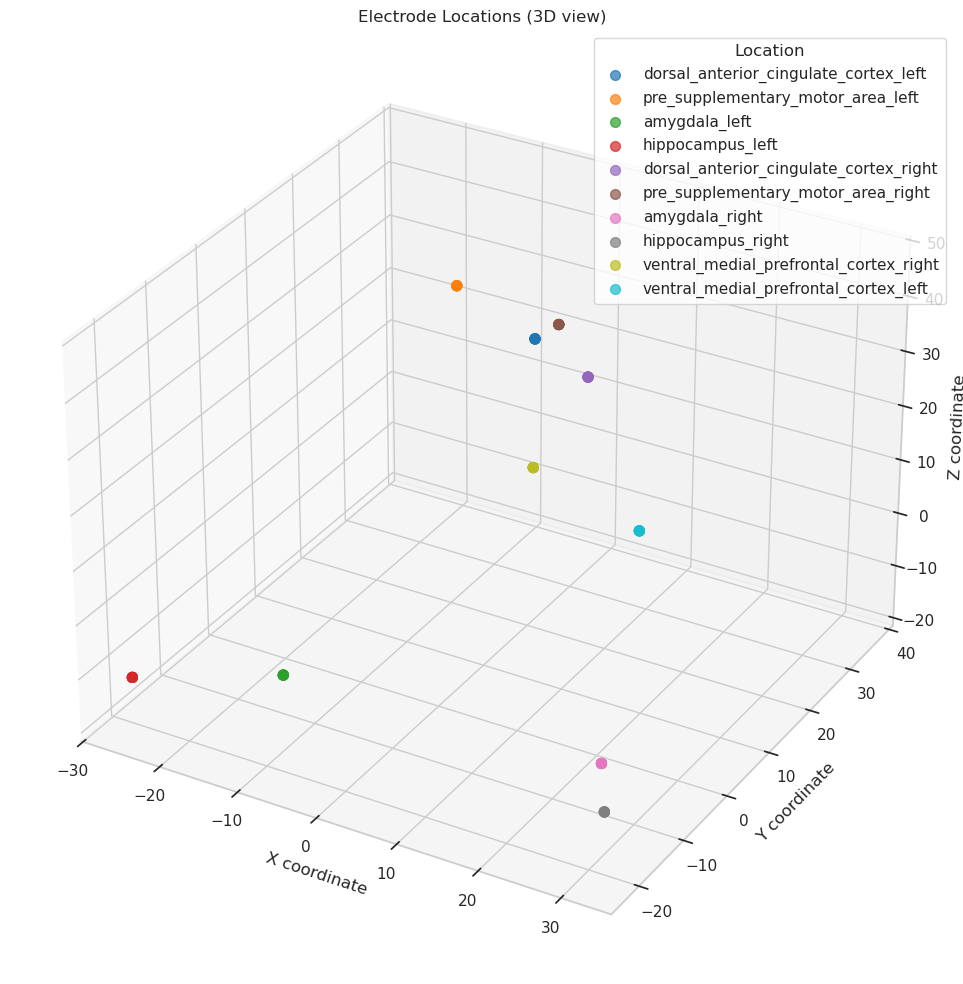

In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Setup figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a color map for the different brain regions
unique_locations = electrodes_df['location'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_locations)))
color_map = {loc: colors[i] for i, loc in enumerate(unique_locations)}

# Plot each location with a different color
for location in unique_locations:
    subset = electrodes_df[electrodes_df['location'] == location]
    ax.scatter(subset['x'], subset['y'], subset['z'], 
              c=[color_map[location]], label=location, alpha=0.7, s=50)

ax.set_title('Electrode Locations (3D view)')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_zlabel('Z coordinate')
ax.legend(title='Location')

plt.tight_layout()
plt.show()

We can also create a 2D view to better understand the distribution of electrodes on the X-Y plane:

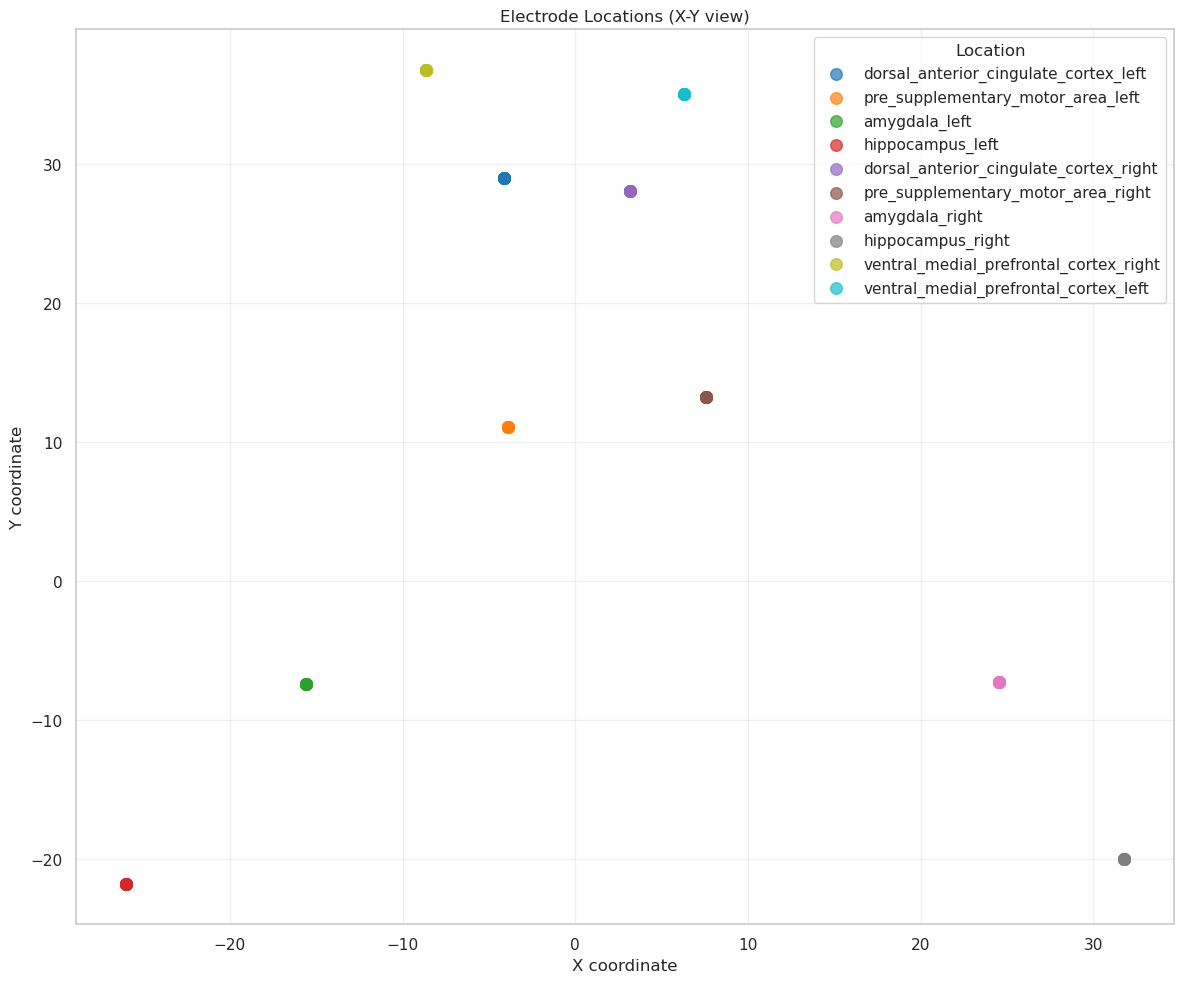

In [9]:
# 2D plot (X-Y view)
plt.figure(figsize=(12, 10))

# Plot each location with a different color
for location in unique_locations:
    subset = electrodes_df[electrodes_df['location'] == location]
    plt.scatter(subset['x'], subset['y'], 
               c=[color_map[location]], label=location, alpha=0.7, s=70)

plt.title('Electrode Locations (X-Y view)')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True, alpha=0.3)
plt.legend(title='Location')

plt.tight_layout()
plt.show()

## Exploring the Neural Units (Neurons)

Let's explore the units (neurons) recorded in this dataset:

In [10]:
# Get information about the units
units_df = nwb.units.to_dataframe()
print(f"Number of units: {len(units_df)}")
print(f"Columns in units dataframe: {units_df.columns.tolist()}")

# Count spike times
spike_counts = []
for _, unit in units_df.iterrows():
    if 'spike_times' in unit and unit['spike_times'] is not None:
        spike_counts.append(len(unit['spike_times']))
    else:
        spike_counts.append(0)

units_df['spike_count'] = spike_counts

print(f"Total spike count: {sum(spike_counts)}")
print(f"Mean spikes per unit: {np.mean(spike_counts):.2f}")
print(f"Max spikes per unit: {np.max(spike_counts)}")

Number of units: 46
Columns in units dataframe: ['spike_times', 'electrodes', 'clusterID_orig', 'waveforms', 'waveforms_mean_snr', 'waveforms_peak_snr', 'waveforms_isolation_distance', 'waveforms_mean_proj_dist']
Total spike count: 168355
Mean spikes per unit: 3659.89
Max spikes per unit: 19308


Let's add electrode location information to these units for better interpretation:

In [11]:
# Function to get electrode location for a unit
def get_electrode_location(unit_row):
    electrode_idx = None
    
    # Check if electrodes column exists and is valid
    if 'electrodes' in unit_row and not pd.isna(unit_row['electrodes']):
        try:
            # Handle different types of indexing
            if hasattr(unit_row['electrodes'], 'item'):
                electrode_idx = unit_row['electrodes'].item()
            elif isinstance(unit_row['electrodes'], (int, np.integer)):
                electrode_idx = unit_row['electrodes']
        except:
            return 'Unknown'
    
    if electrode_idx is not None and electrode_idx < len(electrodes_df):
        return electrodes_df.iloc[electrode_idx]['location']
    return 'Unknown'

# Try to add location information to units when possible
try:
    units_df['location'] = units_df.apply(get_electrode_location, axis=1)
    
    # Count units by brain region
    unit_counts = units_df['location'].value_counts()
    print("\nUnits by brain region:")
    for region, count in unit_counts.items():
        print(f"  {region}: {count}")
except Exception as e:
    print(f"Could not add location information to units: {e}")
    # If there's an error, we'll continue without this information

Could not add location information to units: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().


## Analyzing the Behavioral Task and Performance

Now that we've explored the recording locations, let's analyze the behavioral data from the Sternberg working memory task.

In [12]:
# Get trials data as DataFrame
trials_df = nwb.trials.to_dataframe()

# Basic trial information
print(f"Number of trials: {len(trials_df)}")
print(f"Trial columns: {trials_df.columns.tolist()}")

# Check memory loads
loads = trials_df['loads'].astype(int)
load_counts = loads.value_counts().sort_index()
print(f"\nMemory loads: {load_counts.index.tolist()}")
print(f"Count per load: {load_counts.values.tolist()}")

# Calculate accuracy by memory load
accuracy_by_load = trials_df.groupby('loads')['response_accuracy'].mean() * 100
print("\nAccuracy by memory load:")
for load, acc in accuracy_by_load.items():
    print(f"  Load {int(load)}: {acc:.1f}%")

Number of trials: 140
Trial columns: ['loads', 'PicIDs_Encoding1', 'PicIDs_Encoding2', 'PicIDs_Encoding3', 'PicIDs_Probe', 'start_time', 'stop_time', 'timestamps_FixationCross', 'timestamps_Encoding1', 'timestamps_Encoding1_end', 'timestamps_Encoding2', 'timestamps_Encoding2_end', 'timestamps_Encoding3', 'timestamps_Encoding3_end', 'timestamps_Maintenance', 'timestamps_Probe', 'timestamps_Response', 'response_accuracy', 'probe_in_out']

Memory loads: [1, 3]
Count per load: [70, 70]

Accuracy by memory load:
  Load 1: 100.0%
  Load 3: 94.3%


### Visualizing Task Performance

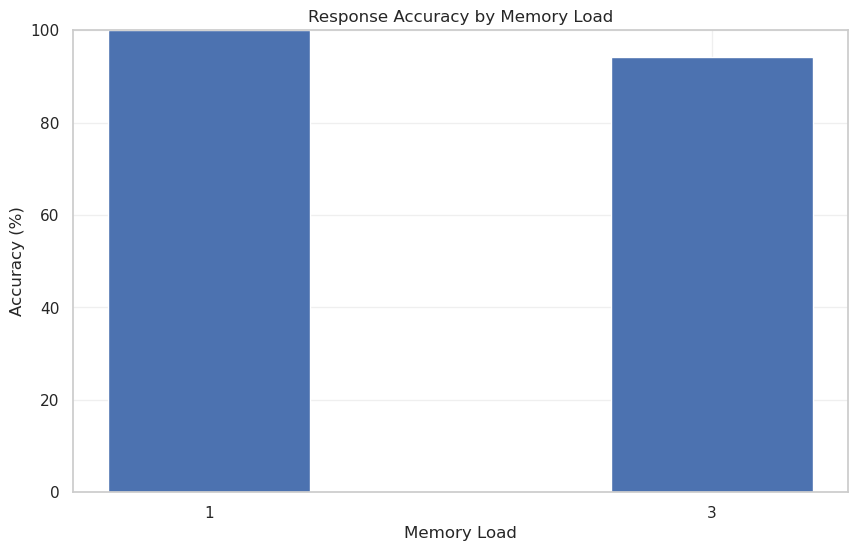

In [13]:
# Plot accuracy by memory load
plt.figure(figsize=(10, 6))
plt.bar(accuracy_by_load.index.astype(int), accuracy_by_load.values)
plt.xlabel('Memory Load')
plt.ylabel('Accuracy (%)')
plt.title('Response Accuracy by Memory Load')
plt.xticks(accuracy_by_load.index.astype(int))
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()

Let's analyze the response times in relation to memory load and accuracy:

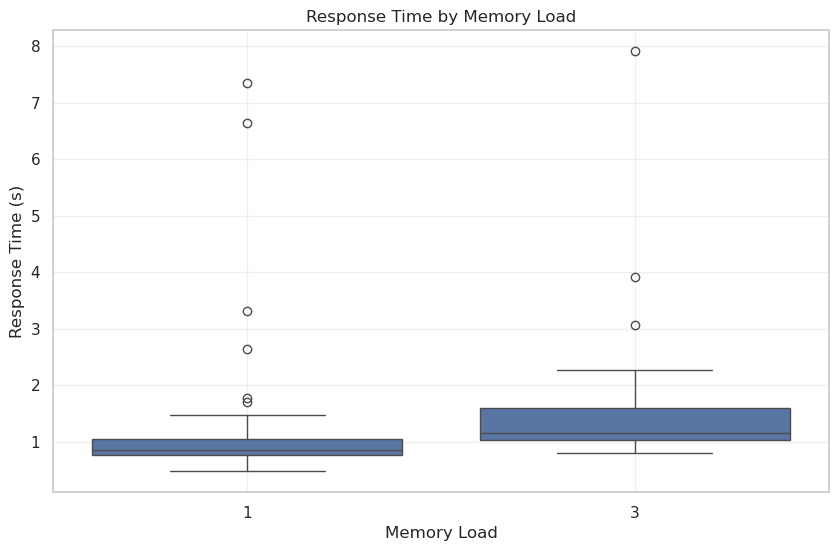

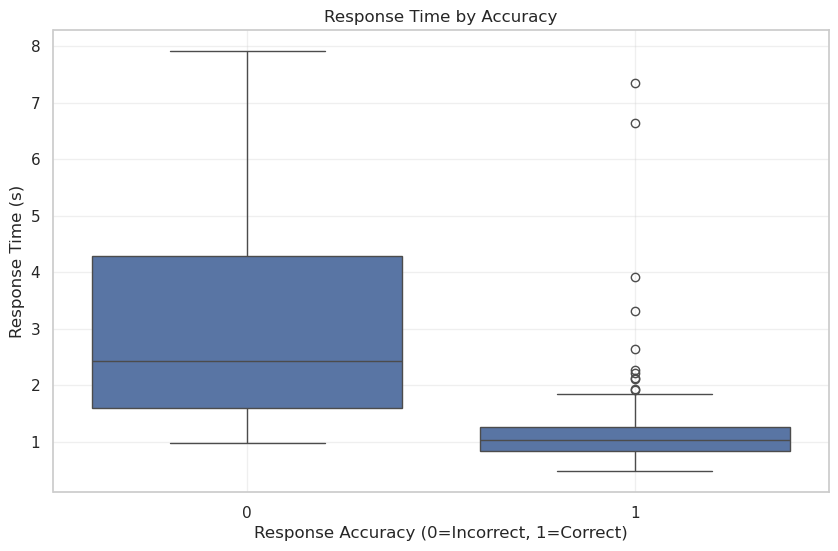

In [14]:
# Calculate response times
trials_df['response_time'] = trials_df['timestamps_Response'] - trials_df['timestamps_Probe']

# Plot response times by memory load
plt.figure(figsize=(10, 6))
sns.boxplot(x=trials_df['loads'].astype(int), y=trials_df['response_time'])
plt.xlabel('Memory Load')
plt.ylabel('Response Time (s)')
plt.title('Response Time by Memory Load')
plt.grid(True, alpha=0.3)
plt.show()

# Plot response times by accuracy
plt.figure(figsize=(10, 6))
sns.boxplot(x=trials_df['response_accuracy'].astype(int), y=trials_df['response_time'])
plt.xlabel('Response Accuracy (0=Incorrect, 1=Correct)')
plt.ylabel('Response Time (s)')
plt.title('Response Time by Accuracy')
plt.grid(True, alpha=0.3)
plt.show()

### Visualizing Trial Structure

Let's visualize the temporal structure of the trials to better understand the task:

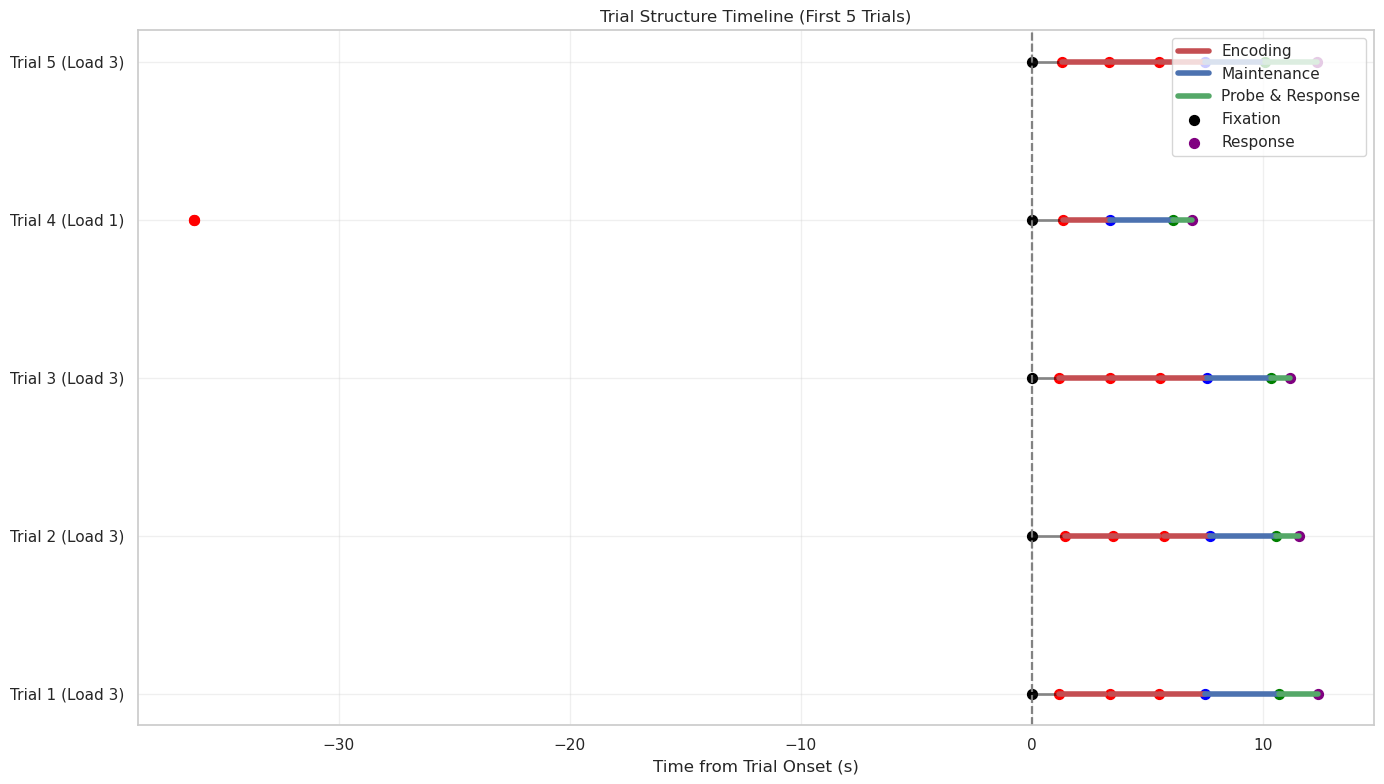

In [15]:
# For clarity, we'll visualize the first 5 trials
sample_trials = trials_df.iloc[0:5]

# Create a timeline figure
plt.figure(figsize=(14, 8))

# Plot timeline for sample trials
for i, (idx, trial) in enumerate(sample_trials.iterrows()):
    # Calculate start times relative to trial start
    rel_fixation = trial['timestamps_FixationCross'] - trial['start_time']
    rel_enc1 = trial['timestamps_Encoding1'] - trial['start_time']
    rel_enc1_end = trial['timestamps_Encoding1_end'] - trial['start_time']
    rel_enc2 = trial['timestamps_Encoding2'] - trial['start_time'] if not np.isnan(trial['timestamps_Encoding2']) else None
    rel_enc2_end = trial['timestamps_Encoding2_end'] - trial['start_time'] if not np.isnan(trial['timestamps_Encoding2_end']) else None
    rel_enc3 = trial['timestamps_Encoding3'] - trial['start_time'] if not np.isnan(trial['timestamps_Encoding3']) else None
    rel_enc3_end = trial['timestamps_Encoding3_end'] - trial['start_time'] if not np.isnan(trial['timestamps_Encoding3_end']) else None
    rel_maint = trial['timestamps_Maintenance'] - trial['start_time']
    rel_probe = trial['timestamps_Probe'] - trial['start_time']
    rel_resp = trial['timestamps_Response'] - trial['start_time']
    
    # Plot trial phases
    plt.plot([rel_fixation, rel_enc1], [i, i], 'k-', linewidth=2, alpha=0.5)
    plt.axvline(x=rel_fixation, color='gray', linestyle='--', alpha=0.5)
    
    # Encoding 1
    plt.plot([rel_enc1, rel_enc1_end], [i, i], 'r-', linewidth=4, label='Encoding' if i == 0 else "")
    
    # Encoding 2 (if present)
    if rel_enc2 is not None and rel_enc2_end is not None:
        plt.plot([rel_enc2, rel_enc2_end], [i, i], 'r-', linewidth=4)
    
    # Encoding 3 (if present)
    if rel_enc3 is not None and rel_enc3_end is not None:
        plt.plot([rel_enc3, rel_enc3_end], [i, i], 'r-', linewidth=4)
    
    # Maintenance
    plt.plot([rel_maint, rel_probe], [i, i], 'b-', linewidth=4, label='Maintenance' if i == 0 else "")
    
    # Probe and response
    plt.plot([rel_probe, rel_resp], [i, i], 'g-', linewidth=4, label='Probe & Response' if i == 0 else "")
    
    # Add markers for key events
    plt.scatter(rel_fixation, i, color='black', s=50, label='Fixation' if i == 0 else "")
    plt.scatter(rel_enc1, i, color='red', s=50)
    if rel_enc2 is not None:
        plt.scatter(rel_enc2, i, color='red', s=50)
    if rel_enc3 is not None:
        plt.scatter(rel_enc3, i, color='red', s=50)
    plt.scatter(rel_maint, i, color='blue', s=50)
    plt.scatter(rel_probe, i, color='green', s=50)
    plt.scatter(rel_resp, i, color='purple', s=50, label='Response' if i == 0 else "")

# Add load information to y-axis labels
trial_labels = [f"Trial {i+1} (Load {int(trial['loads'])})" for i, (_, trial) in enumerate(sample_trials.iterrows())]
plt.yticks(range(len(sample_trials)), trial_labels)

plt.xlabel('Time from Trial Onset (s)')
plt.title('Trial Structure Timeline (First 5 Trials)')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Analyzing LFP Data

Now let's explore the Local Field Potential (LFP) data, which represents the summed electrical activity of large populations of neurons. These signals can reveal important oscillatory patterns related to cognitive processes.

In [16]:
# Get basic information about the LFP data
lfp = nwb.acquisition["LFPs"]
print(f"LFP data shape: {lfp.data.shape}")
print(f"LFP sampling rate: {lfp.rate} Hz")
print(f"LFP description: {lfp.description}")

LFP data shape: (550276, 70)
LFP sampling rate: 400.0 Hz
LFP description: These are LFP recordings that have spike potentials removed and is downsampled to 400Hz


### Visualizing LFP Traces from Different Brain Regions

Let's select a few channels from different brain regions and plot their LFP traces:

In [17]:
# Extract a sample of LFP data (5 seconds)
sample_duration = 5  # seconds
start_time = 200  # seconds into the recording
start_idx = int(start_time * lfp.rate)
end_idx = start_idx + int(sample_duration * lfp.rate)

# Ensure indices are within range
end_idx = min(end_idx, lfp.data.shape[0])
if end_idx <= start_idx:
    start_idx = 0
    end_idx = min(int(sample_duration * lfp.rate), lfp.data.shape[0])

# Select representative channels from different brain regions
region_names = electrodes_df['location'].unique()
selected_channels = []
channel_regions = []

# Try to get one channel from each unique region
for region in region_names:
    region_electrodes = electrodes_df[electrodes_df['location'] == region].index.tolist()
    if region_electrodes and len(selected_channels) < 6:  # Limit to 6 channels for clear visualization
        channel_idx = region_electrodes[0]  # Take the first channel from this region
        if channel_idx < lfp.data.shape[1]:  # Ensure it's within bounds
            selected_channels.append(int(channel_idx))
            channel_regions.append(region)

# If we couldn't get channels from different regions, just use the first few available
if not selected_channels:
    selected_channels = list(range(min(6, lfp.data.shape[1])))
    channel_regions = ['Unknown'] * len(selected_channels)

print(f"Selected channels: {selected_channels}")
print(f"Corresponding regions: {channel_regions}")

# Extract LFP data for selected channels
lfp_sample = np.zeros((end_idx - start_idx, len(selected_channels)))
for i, channel_idx in enumerate(selected_channels):
    lfp_sample[:, i] = lfp.data[start_idx:end_idx, channel_idx]

# Create time array
time = np.arange(lfp_sample.shape[0]) / lfp.rate

Selected channels: [0, 8, 15, 22, 29, 37]
Corresponding regions: ['dorsal_anterior_cingulate_cortex_left', 'pre_supplementary_motor_area_left', 'amygdala_left', 'hippocampus_left', 'dorsal_anterior_cingulate_cortex_right', 'pre_supplementary_motor_area_right']


Now let's plot the LFP traces for these selected channels:

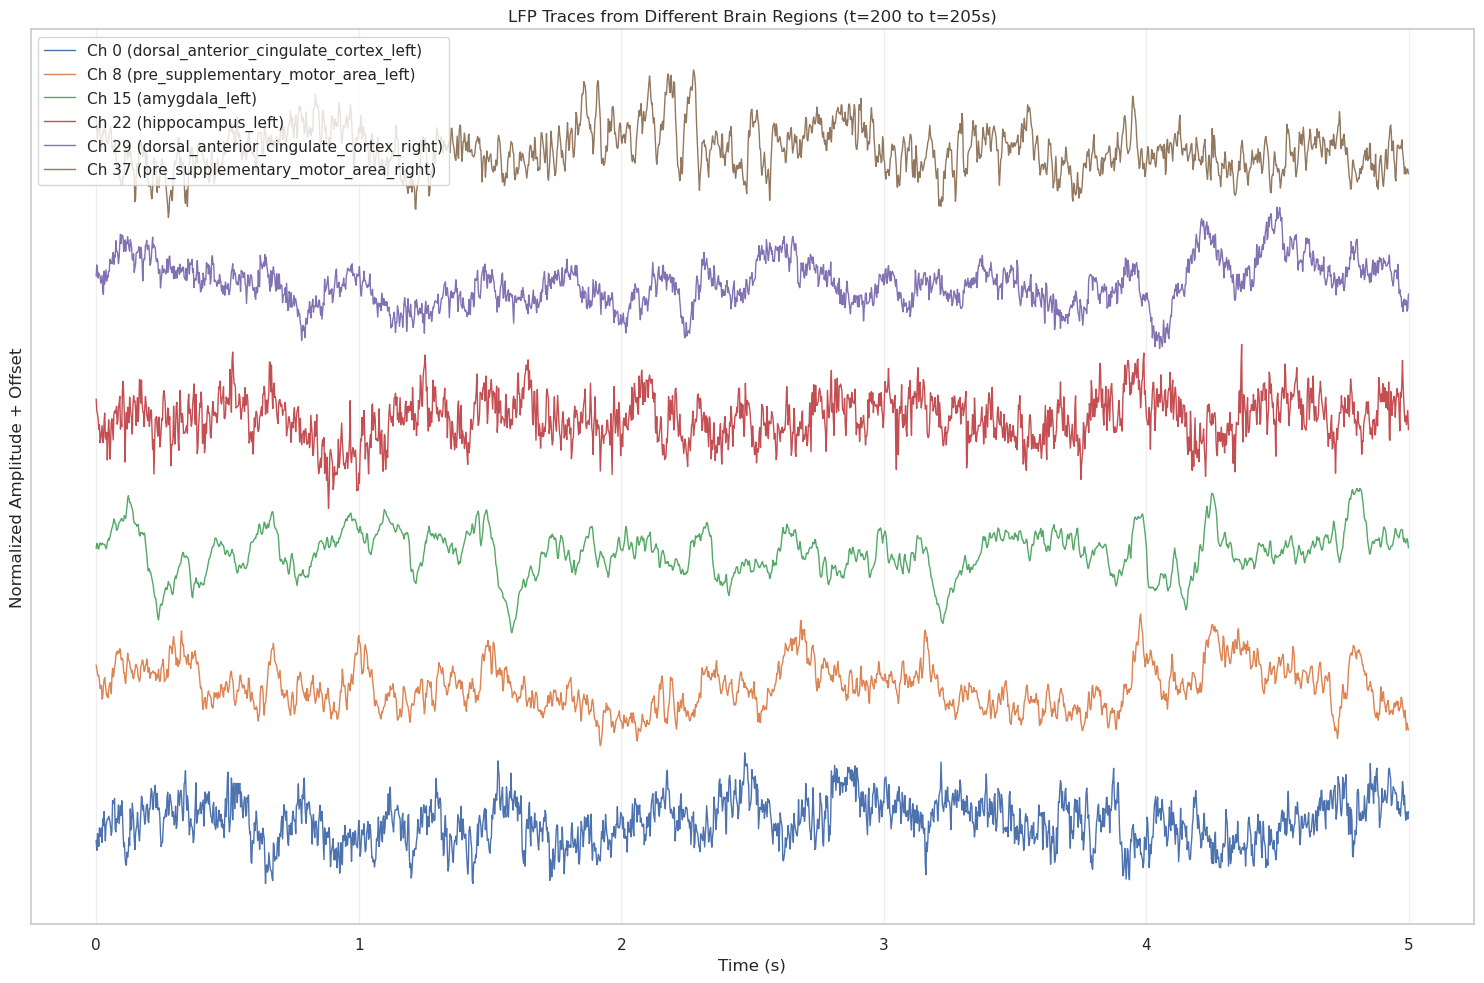

In [18]:
# Plot LFP traces
plt.figure(figsize=(15, 10))

for i, (channel_idx, region) in enumerate(zip(selected_channels, channel_regions)):
    # Normalize and offset each signal for better visualization
    signal_data = lfp_sample[:, i]
    normalized = (signal_data - np.mean(signal_data)) / np.std(signal_data)
    offset = i * 6  # Increase vertical separation
    plt.plot(time, normalized + offset, linewidth=1, label=f"Ch {channel_idx} ({region})")

plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude + Offset')
plt.title(f'LFP Traces from Different Brain Regions (t={start_time} to t={start_time+sample_duration}s)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yticks([])  # Hide y-axis ticks as they're not meaningful with offsets
plt.tight_layout()
plt.show()

### Analyzing Frequency Content of LFP Signals

Let's compute the power spectral density (PSD) to see the frequency content of these signals:

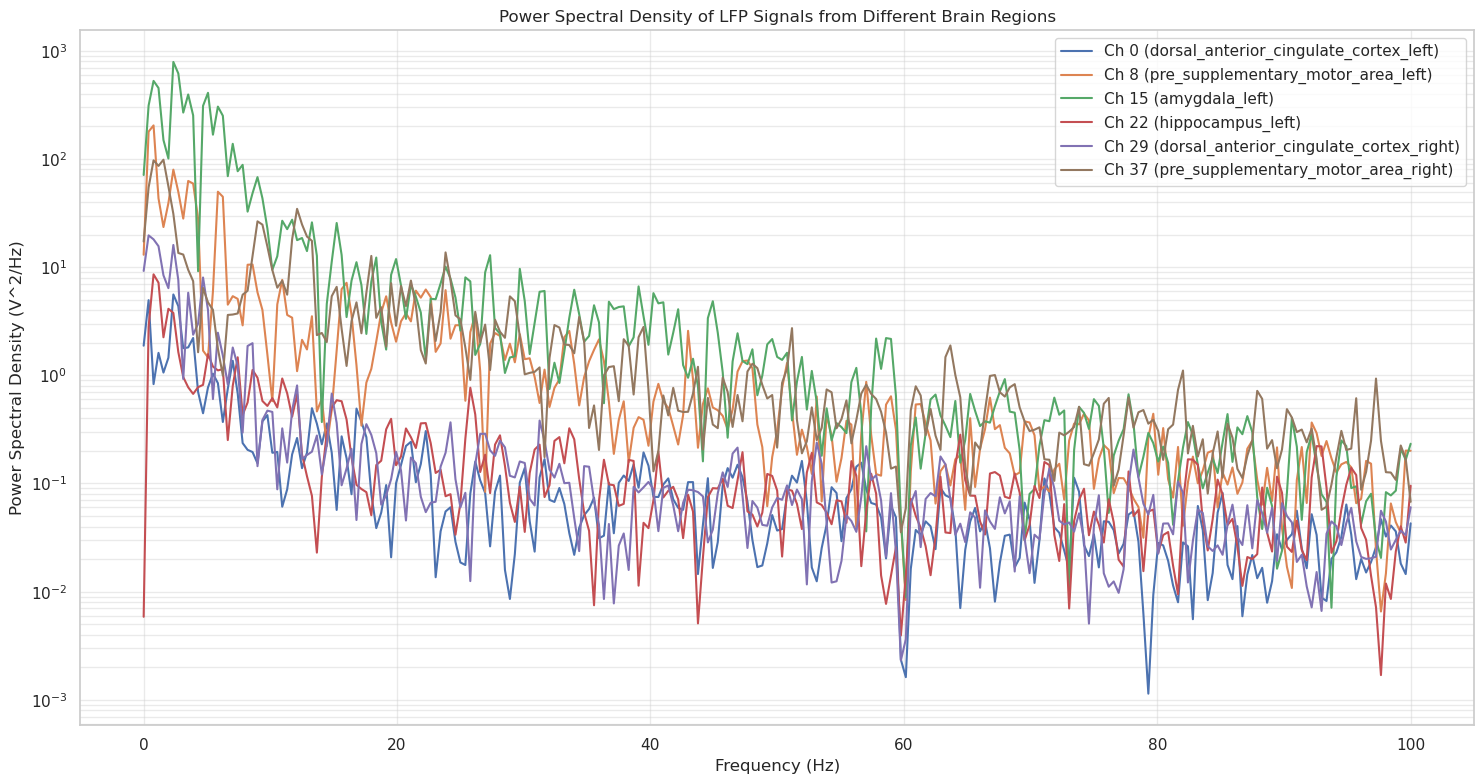

In [19]:
# Calculate and plot power spectral density for each channel
plt.figure(figsize=(15, 8))

for i, (channel_idx, region) in enumerate(zip(selected_channels, channel_regions)):
    # Calculate PSD
    f, psd = signal.welch(lfp_sample[:, i], lfp.rate, nperseg=min(1024, lfp_sample.shape[0]))
    
    # Plot only up to 100 Hz
    mask = f <= 100
    plt.semilogy(f[mask], psd[mask], label=f"Ch {channel_idx} ({region})")

plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title('Power Spectral Density of LFP Signals from Different Brain Regions')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.tight_layout()
plt.show()

### Extracting and Visualizing Frequency Bands

Brain oscillations are often analyzed in specific frequency bands that have been associated with different cognitive functions:

- Delta (0.5-4 Hz): Associated with deep sleep
- Theta (4-8 Hz): Associated with memory and spatial navigation
- Alpha (8-12 Hz): Associated with relaxed wakefulness
- Beta (12-30 Hz): Associated with active thinking and focus
- Gamma (30-100 Hz): Associated with cognitive processing and conscious attention

Let's focus on the theta band (4-8 Hz), which is particularly relevant for working memory:

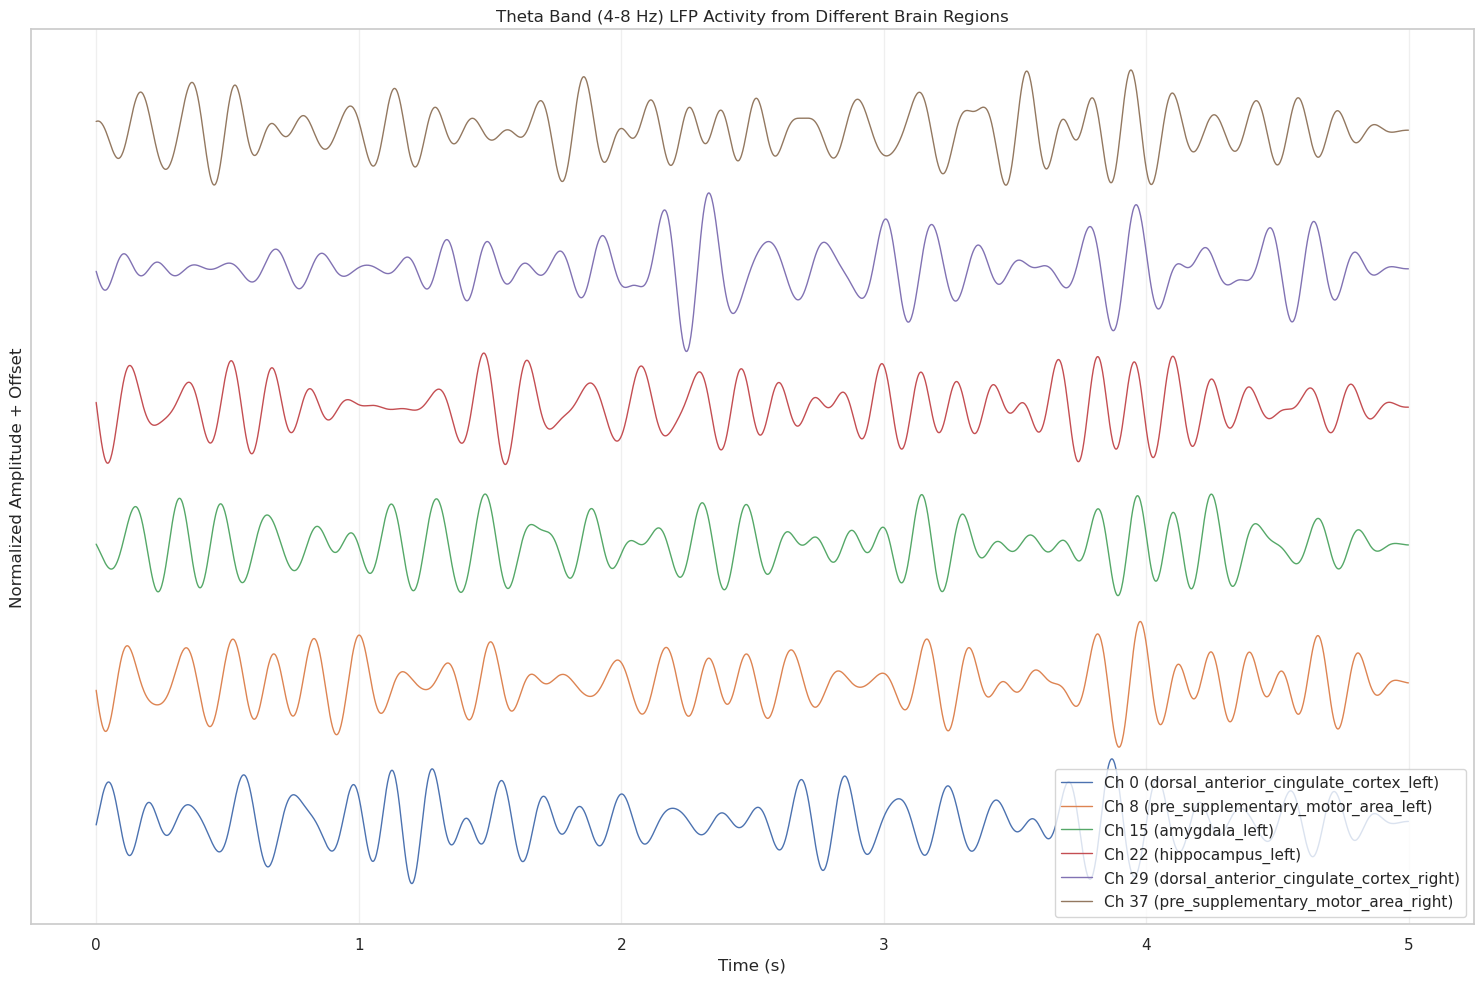

In [20]:
# Filter data to extract theta band (4-8 Hz)
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

# Filter each channel to get theta band
theta_data = np.zeros_like(lfp_sample)
for i in range(lfp_sample.shape[1]):
    theta_data[:, i] = bandpass_filter(lfp_sample[:, i], 4, 8, lfp.rate)

# Plot filtered signals
plt.figure(figsize=(15, 10))

for i, (channel_idx, region) in enumerate(zip(selected_channels, channel_regions)):
    # Normalize and offset each signal for better visualization
    signal_data = theta_data[:, i]
    normalized = (signal_data - np.mean(signal_data)) / np.std(signal_data)
    offset = i * 6  # Increase vertical separation
    plt.plot(time, normalized + offset, linewidth=1, label=f"Ch {channel_idx} ({region})")

plt.xlabel('Time (s)')
plt.ylabel('Normalized Amplitude + Offset')
plt.title('Theta Band (4-8 Hz) LFP Activity from Different Brain Regions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yticks([])  # Hide y-axis ticks as they're not meaningful with offsets
plt.tight_layout()
plt.show()

### Theta Power Over Time

Let's also compute and visualize the theta power envelope over time using the Hilbert transform:

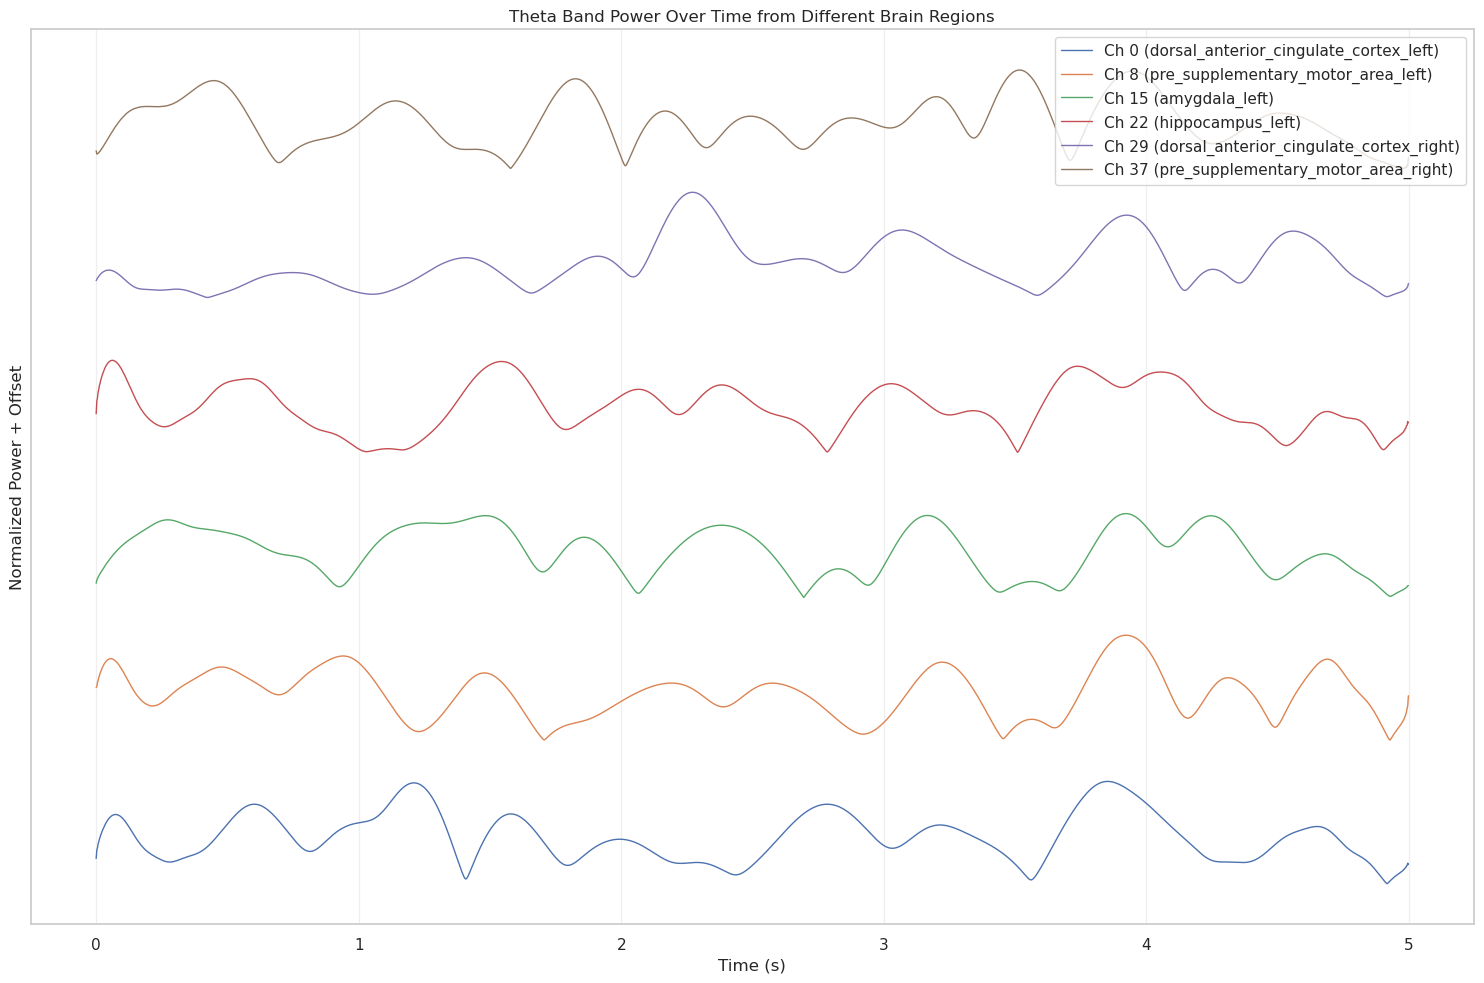

In [21]:
# Calculate theta power over time using the Hilbert transform
theta_power = np.zeros_like(theta_data)
for i in range(theta_data.shape[1]):
    analytic_signal = signal.hilbert(theta_data[:, i])
    amplitude_envelope = np.abs(analytic_signal)
    theta_power[:, i] = amplitude_envelope

# Plot theta power
plt.figure(figsize=(15, 10))

for i, (channel_idx, region) in enumerate(zip(selected_channels, channel_regions)):
    # Normalize and offset each power trace for better visualization
    power_data = theta_power[:, i]
    normalized = (power_data - np.mean(power_data)) / np.std(power_data)
    offset = i * 6  # Increase vertical separation
    plt.plot(time, normalized + offset, linewidth=1, label=f"Ch {channel_idx} ({region})")

plt.xlabel('Time (s)')
plt.ylabel('Normalized Power + Offset')
plt.title('Theta Band Power Over Time from Different Brain Regions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yticks([])  # Hide y-axis ticks as they're not meaningful with offsets
plt.tight_layout()
plt.show()

## Neural Activity Around Trial Events

Let's look at how LFP activity changes around specific trial events like stimulus presentation and response:

In [22]:
# Extract LFP activity around encoding stimuli
def extract_event_lfp(lfp_data, event_times, pre_time, post_time, sampling_rate):
    window_samples = int((pre_time + post_time) * sampling_rate)
    result = np.zeros((len(event_times), window_samples, lfp_data.shape[1]))
    time_vector = np.linspace(-pre_time, post_time, window_samples)
    
    for i, event_time in enumerate(event_times):
        start_idx = int((event_time - pre_time) * sampling_rate)
        end_idx = start_idx + window_samples
        
        if start_idx >= 0 and end_idx < lfp_data.shape[0]:
            result[i] = lfp_data[start_idx:end_idx]
    
    return result, time_vector

# Extract LFP around encoding stimulus presentation (for first 20 trials)
encoding_times = trials_df['timestamps_Encoding1'].values[:20]
pre_time = 1.0  # 1 second before event
post_time = 2.0  # 2 seconds after event

encoding_lfp, encoding_time = extract_event_lfp(
    lfp.data, encoding_times, pre_time, post_time, lfp.rate)

Now let's visualize the average LFP response to the first encoding stimulus:

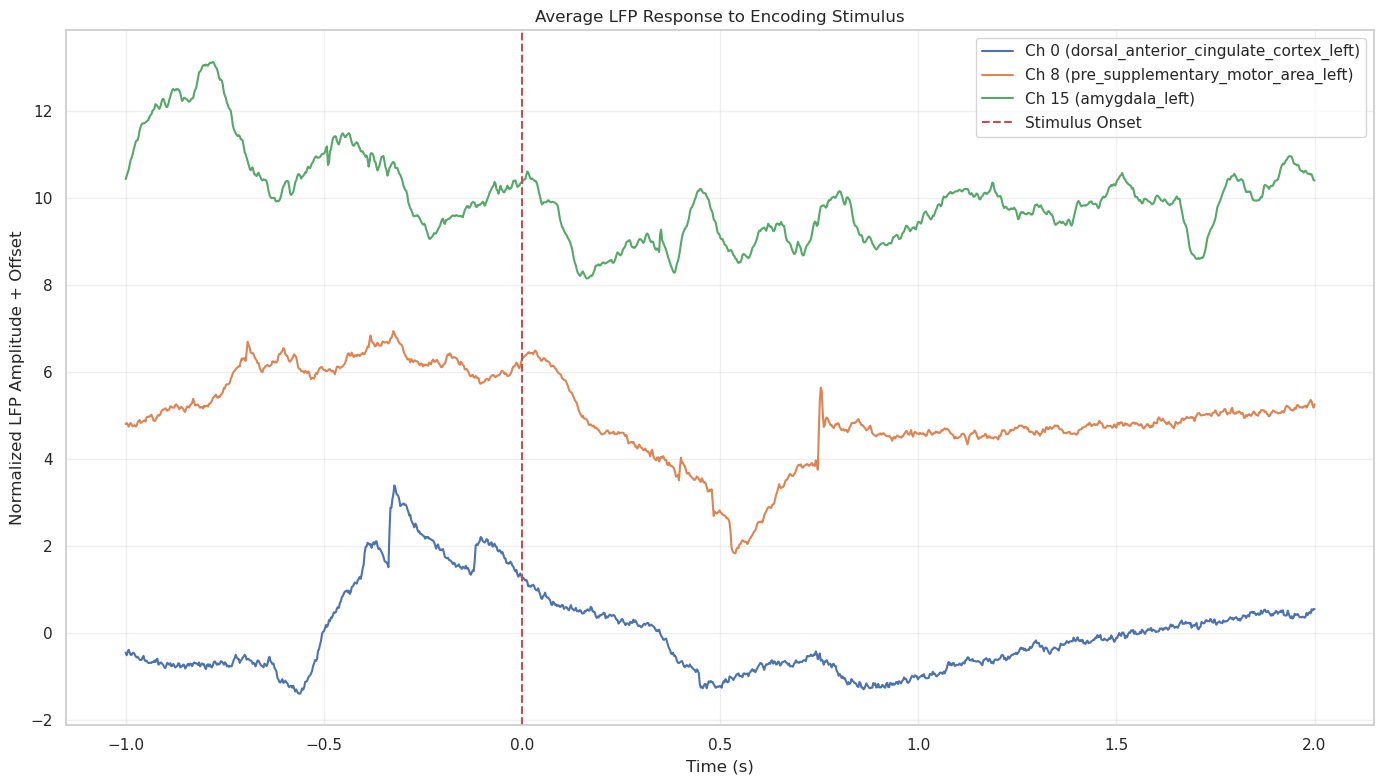

In [23]:
# Calculate average LFP response to encoding stimulus for each channel
avg_encoding_response = np.mean(encoding_lfp, axis=0)

# Plot for a few selected channels
plt.figure(figsize=(14, 8))

for i, (channel_idx, region) in enumerate(zip(selected_channels[:3], channel_regions[:3])):
    if channel_idx < avg_encoding_response.shape[1]:
        # Extract data for this channel
        channel_data = avg_encoding_response[:, channel_idx]
        
        # Normalize for better visualization
        normalized = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        
        # Plot with offset
        plt.plot(encoding_time, normalized + i*5, label=f"Ch {channel_idx} ({region})")

plt.axvline(x=0, color='r', linestyle='--', label='Stimulus Onset')
plt.xlabel('Time (s)')
plt.ylabel('Normalized LFP Amplitude + Offset')
plt.title('Average LFP Response to Encoding Stimulus')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Let's do the same for the probe stimulus:

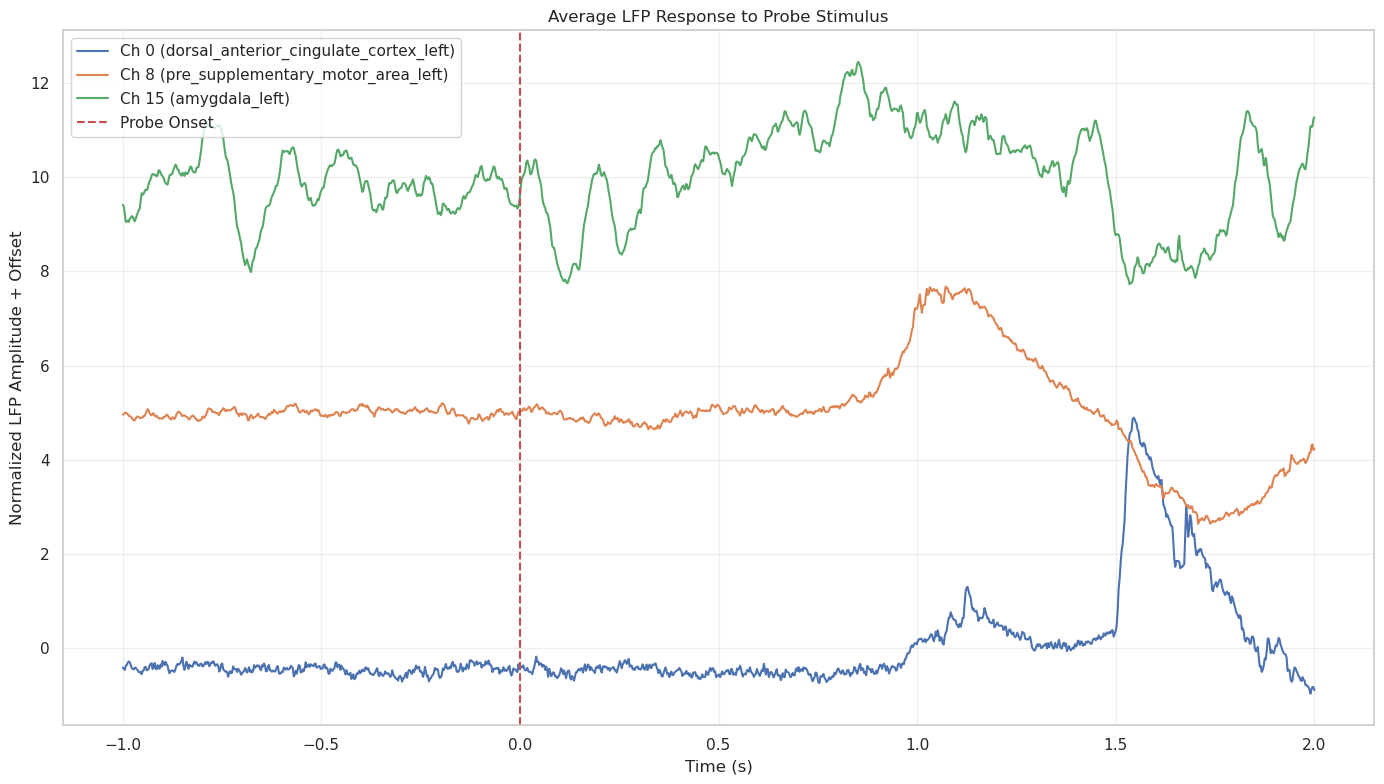

In [24]:
# Extract LFP around probe stimulus presentation (for first 20 trials)
probe_times = trials_df['timestamps_Probe'].values[:20]

probe_lfp, probe_time = extract_event_lfp(
    lfp.data, probe_times, pre_time, post_time, lfp.rate)

# Calculate average LFP response to probe stimulus for each channel
avg_probe_response = np.mean(probe_lfp, axis=0)

# Plot for a few selected channels
plt.figure(figsize=(14, 8))

for i, (channel_idx, region) in enumerate(zip(selected_channels[:3], channel_regions[:3])):
    if channel_idx < avg_probe_response.shape[1]:
        # Extract data for this channel
        channel_data = avg_probe_response[:, channel_idx]
        
        # Normalize for better visualization
        normalized = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        
        # Plot with offset
        plt.plot(probe_time, normalized + i*5, label=f"Ch {channel_idx} ({region})")

plt.axvline(x=0, color='r', linestyle='--', label='Probe Onset')
plt.xlabel('Time (s)')
plt.ylabel('Normalized LFP Amplitude + Offset')
plt.title('Average LFP Response to Probe Stimulus')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analyzing Neural Activity by Memory Load

One of the key aspects of the Sternberg task is manipulating memory load. Let's compare neural activity between different memory load conditions:

In [25]:
# Separate trials by memory load
load1_trials = trials_df[trials_df['loads'] == 1]
load3_trials = trials_df[trials_df['loads'] == 3]

# Extract maintenance period LFP for different memory loads
def extract_maintenance_lfp(lfp_data, trials, sampling_rate):
    results = []
    
    for _, trial in trials.iterrows():
        start_time = trial['timestamps_Maintenance']
        end_time = trial['timestamps_Probe']
        
        if not (np.isnan(start_time) or np.isnan(end_time)):
            start_idx = int(start_time * sampling_rate)
            end_idx = int(end_time * sampling_rate)
            
            if start_idx >= 0 and end_idx < lfp_data.shape[0]:
                # Get LFP data during maintenance period
                trial_data = lfp_data[start_idx:end_idx]
                
                # We'll use a fixed length for easier comparison
                fixed_length = int(1.0 * sampling_rate)  # 1 second
                if trial_data.shape[0] >= fixed_length:
                    results.append(trial_data[:fixed_length])
    
    # Stack all trials together
    if results:
        return np.stack(results)
    else:
        return np.array([])

# Extract maintenance LFP for each load condition
load1_maintenance = extract_maintenance_lfp(lfp.data, load1_trials.head(10), lfp.rate)
load3_maintenance = extract_maintenance_lfp(lfp.data, load3_trials.head(10), lfp.rate)

Now let's compare the power spectra during maintenance between the two load conditions:

In [26]:
# Calculate PSD for each load condition
def calculate_maintenance_psd(maintenance_data, sampling_rate):
    n_trials = maintenance_data.shape[0]
    n_channels = maintenance_data.shape[2]
    
    # We'll use Welch's method with appropriate parameters
    nperseg = min(256, maintenance_data.shape[1])
    
    # Get the frequency axis
    f, _ = signal.welch(maintenance_data[0, :, 0], fs=sampling_rate, nperseg=nperseg)
    
    # Initialize array for power
    psd = np.zeros((len(f), n_channels))
    
    # Calculate PSD for each channel, averaged across trials
    for ch in range(n_channels):
        for trial in range(n_trials):
            f, p = signal.welch(maintenance_data[trial, :, ch], 
                               fs=sampling_rate, 
                               nperseg=nperseg)
            psd[:, ch] += p
        
        psd[:, ch] /= n_trials
    
    return f, psd

Let's plot the comparison for one of our selected channels from a region involved in working memory:

Analyzing channel 22 from hippocampus_left


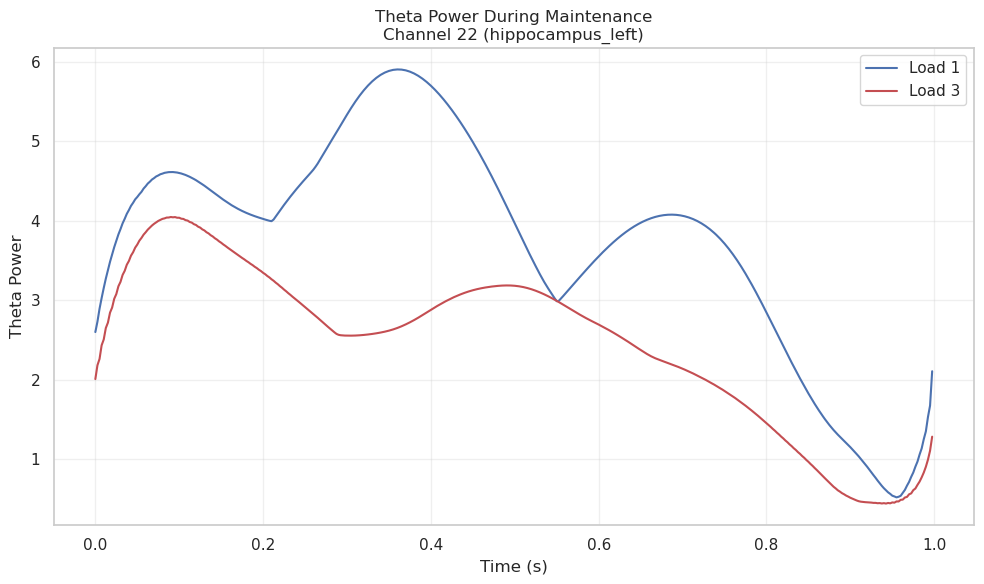

T-test results: t=14.663, p=0.000
Mean theta power - Load 1: 3.735, Load 3: 2.462


In [27]:
# Find a channel from hippocampus or prefrontal cortex for analysis
target_regions = ['hippocampus_left', 'hippocampus_right', 
                 'ventral_medial_prefrontal_cortex_left', 'ventral_medial_prefrontal_cortex_right']

memory_channels = []
for i, region in enumerate(channel_regions):
    if any(target in region for target in target_regions):
        memory_channels.append((selected_channels[i], region))

if memory_channels:
    # Use the first matching channel
    memory_ch_idx, memory_ch_region = memory_channels[0]
    print(f"Analyzing channel {memory_ch_idx} from {memory_ch_region}")
    
    # Compare theta power during maintenance between load conditions
    # First, filter the data to get theta band
    load1_theta = np.zeros_like(load1_maintenance)
    load3_theta = np.zeros_like(load3_maintenance)
    
    for i in range(load1_maintenance.shape[0]):
        load1_theta[i, :, memory_ch_idx] = bandpass_filter(
            load1_maintenance[i, :, memory_ch_idx], 4, 8, lfp.rate)
    
    for i in range(load3_maintenance.shape[0]):
        load3_theta[i, :, memory_ch_idx] = bandpass_filter(
            load3_maintenance[i, :, memory_ch_idx], 4, 8, lfp.rate)
    
    # Calculate mean theta power
    load1_theta_power = np.mean(np.abs(signal.hilbert(load1_theta[:, :, memory_ch_idx])), axis=0)
    load3_theta_power = np.mean(np.abs(signal.hilbert(load3_theta[:, :, memory_ch_idx])), axis=0)
    
    # Plot the comparison
    plt.figure(figsize=(10, 6))
    time_vector = np.arange(load1_theta_power.shape[0]) / lfp.rate
    plt.plot(time_vector, load1_theta_power, 'b-', label='Load 1')
    plt.plot(time_vector, load3_theta_power, 'r-', label='Load 3')
    plt.xlabel('Time (s)')
    plt.ylabel('Theta Power')
    plt.title(f'Theta Power During Maintenance\nChannel {memory_ch_idx} ({memory_ch_region})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Compare means statistically
    t_stat, p_val = ttest_ind(load1_theta_power, load3_theta_power)
    print(f"T-test results: t={t_stat:.3f}, p={p_val:.3f}")
    print(f"Mean theta power - Load 1: {np.mean(load1_theta_power):.3f}, Load 3: {np.mean(load3_theta_power):.3f}")
else:
    print("No channels from target memory regions found in the selected channels.")

## Conclusion

In this notebook, we've explored Dandiset 000673, which contains electrophysiology recordings and behavioral data from human subjects performing a Sternberg working memory task. We've examined:

1. The metadata and structure of the Dandiset
2. The spatial distribution of recording electrodes across different brain regions
3. Behavioral performance in the Sternberg task, including accuracy and response times
4. LFP signals from different brain regions and their frequency characteristics
5. Neural activity patterns around key trial events
6. Differences in neural activity between memory load conditions

This dataset provides a unique opportunity to study how cognitive control regulates working memory through coordination between frontal control regions and hippocampal activity. The theta-gamma phase-amplitude coupling (TG-PAC) highlighted in the original study could be further explored using specialized analyses of these signals.

### Next Steps

Researchers interested in this dataset might consider:

1. Analyzing phase-amplitude coupling between theta and gamma oscillations
2. Examining spike-field coherence between single units and LFPs
3. Comparing neural activity between correct and incorrect trials
4. Investigating functional connectivity between different brain regions
5. Correlating neural measures with individual differences in working memory performance

### References

The original study associated with this dataset is:

Daume, J., Kaminski, J., Schjetnan, A. G. P., et al. (2025). Control of working memory by phase-amplitude coupling of human hippocampal neurons.

Sample code for reproducing key analyses can be found at: https://github.com/rutishauserlab/SBCAT-release-NWB

**Note**: This notebook was automatically generated using AI and may contain imperfections or errors. Always verify results before drawing scientific conclusions. The code is provided as a starting point for your own exploration and analysis.